In [2]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [3]:
import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 21.0.1+12-LTS-29, mixed mode, sharing)
  Starting server from C:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\38066\AppData\Local\Temp\tmpg9x9u2t5
  JVM stdout: C:\Users\38066\AppData\Local\Temp\tmpg9x9u2t5\h2o_38066_started_from_python.out
  JVM stderr: C:\Users\38066\AppData\Local\Temp\tmpg9x9u2t5\h2o_38066_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Kiev
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 8 days
H2O_cluster_name:,H2O_from_python_38066_gx568w
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.952 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [19]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_25.01.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=True,
                                           outliers_features_to_skip=unimportant_features_to_drop)

features_to_drop = []
for feature_name in X.columns:
    if feature_name in unimportant_features_to_drop:
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

train = h2o.H2OFrame(train_df)
test = h2o.H2OFrame(test_df)

True
['dipole_moment', 'FPSA3', 'nHRing', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'PNSA5', 'nN', 'angle_R2X2R1', 'nF', 'nFRing', 'tpsa+f', 'f_freedom', 'f_atom_fraction', 'mol_num_cycles', 'nO', 'nFAHRing', 'angle_R1X1R2', 'distance_between_atoms_in_f_group_centers', 'nC', 'PBF', 'nAHRing', 'mol_volume', 'nFaRing', 'f_to_fg', 'GeomShapeIndex', 'cis/trans', 'PPSA5', 'nFHRing', 'angle_X2X1R1', 'nFaHRing', 'RPCS', 'naRing', 'nFARing', 'dihedral_angle', 'naHRing', 'chirality', 'nARing', 'TASA', 'pKa', 'logP']
FPSA3 [40]
PNSA5 [37, 38]
f_atom_fraction [124]
PBF [40, 71, 127]
logP [82, 83]
Remains rows:106, amount of features: 40
92 14
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
x = train.columns
# x.remove('C1')
y = "pKa"
x.remove(y)

# train[y] = train[y].asfactor()
# test[y] = test[y].asfactor()

aml = H2OAutoML(seed=1, max_runtime_secs_per_model=300)
aml.train(x=x, y=y, training_frame=train, leaderboard_frame=test, fold_column="fold_id")

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))

AutoML progress: |
13:32:46.947: Fold column fold_id will be used for cross-validation. nfolds parameter will be ignored.
13:32:46.961: AutoML: XGBoost is not available; skipping it.


13:32:47.305: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 92.0.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse       mse       mae      rmsle    mean_residual_deviance
DeepLearning_grid_3_AutoML_1_20240129_133246_model_1     0.392312  0.153909  0.32119   0.0557699                  0.153909
DeepLearning_grid_3_AutoML_1_20240129_133246_model_3     0.399344  0.159475  0.347769  0.0594958                  0.159475
DeepLearning_grid_1_AutoML_1_20240129_133246_model_301   0.404604  0.163705  0.303669  0.0546865                  0.163705
StackedEnsemble_BestOfFamily_5_AutoML_1_20240129_133246  0.464215  0.215495  0.348954  0.0536

In [18]:
best_prev_model = h2o.load_model(r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\25.01.24_features\pKa\Only_mol_with_angles_without_outliers(except_dipole)_with_angles(as features)\DeepLearning_grid_3_AutoML_1_20240126_235839_model_3')

top_features = []
for feature_index in range(15):
    top_features.append(best_prev_model.varimp()[feature_index][0])
top_features

unimportant_features_to_drop = []
for feature_name in X.columns:
    if feature_name not in top_features:
        unimportant_features_to_drop.append(feature_name)

unimportant_features_to_drop

['dipole_moment',
 'nHRing',
 'avg_atoms_in_cycle',
 'angle_R2X2R1',
 'nF',
 'nFRing',
 'f_freedom',
 'mol_num_cycles',
 'nFAHRing',
 'distance_between_atoms_in_f_group_centers',
 'nC',
 'nAHRing',
 'mol_volume',
 'nFaRing',
 'nFHRing',
 'angle_X2X1R1',
 'nFaHRing',
 'RPCS',
 'naRing',
 'nFARing',
 'naHRing',
 'chirality',
 'nARing']

In [22]:
best_model = aml.get_best_model()
preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


{'mse': 0.154, 'mae': 0.321, 'r_score': 0.971}

PERMUTATION IMPORTANCE

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
C:\Users\38066\AppData\Local\Temp\ipykernel_11320\2535254719.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])


Text(0.5, 0, 'H2O Feature Importance')

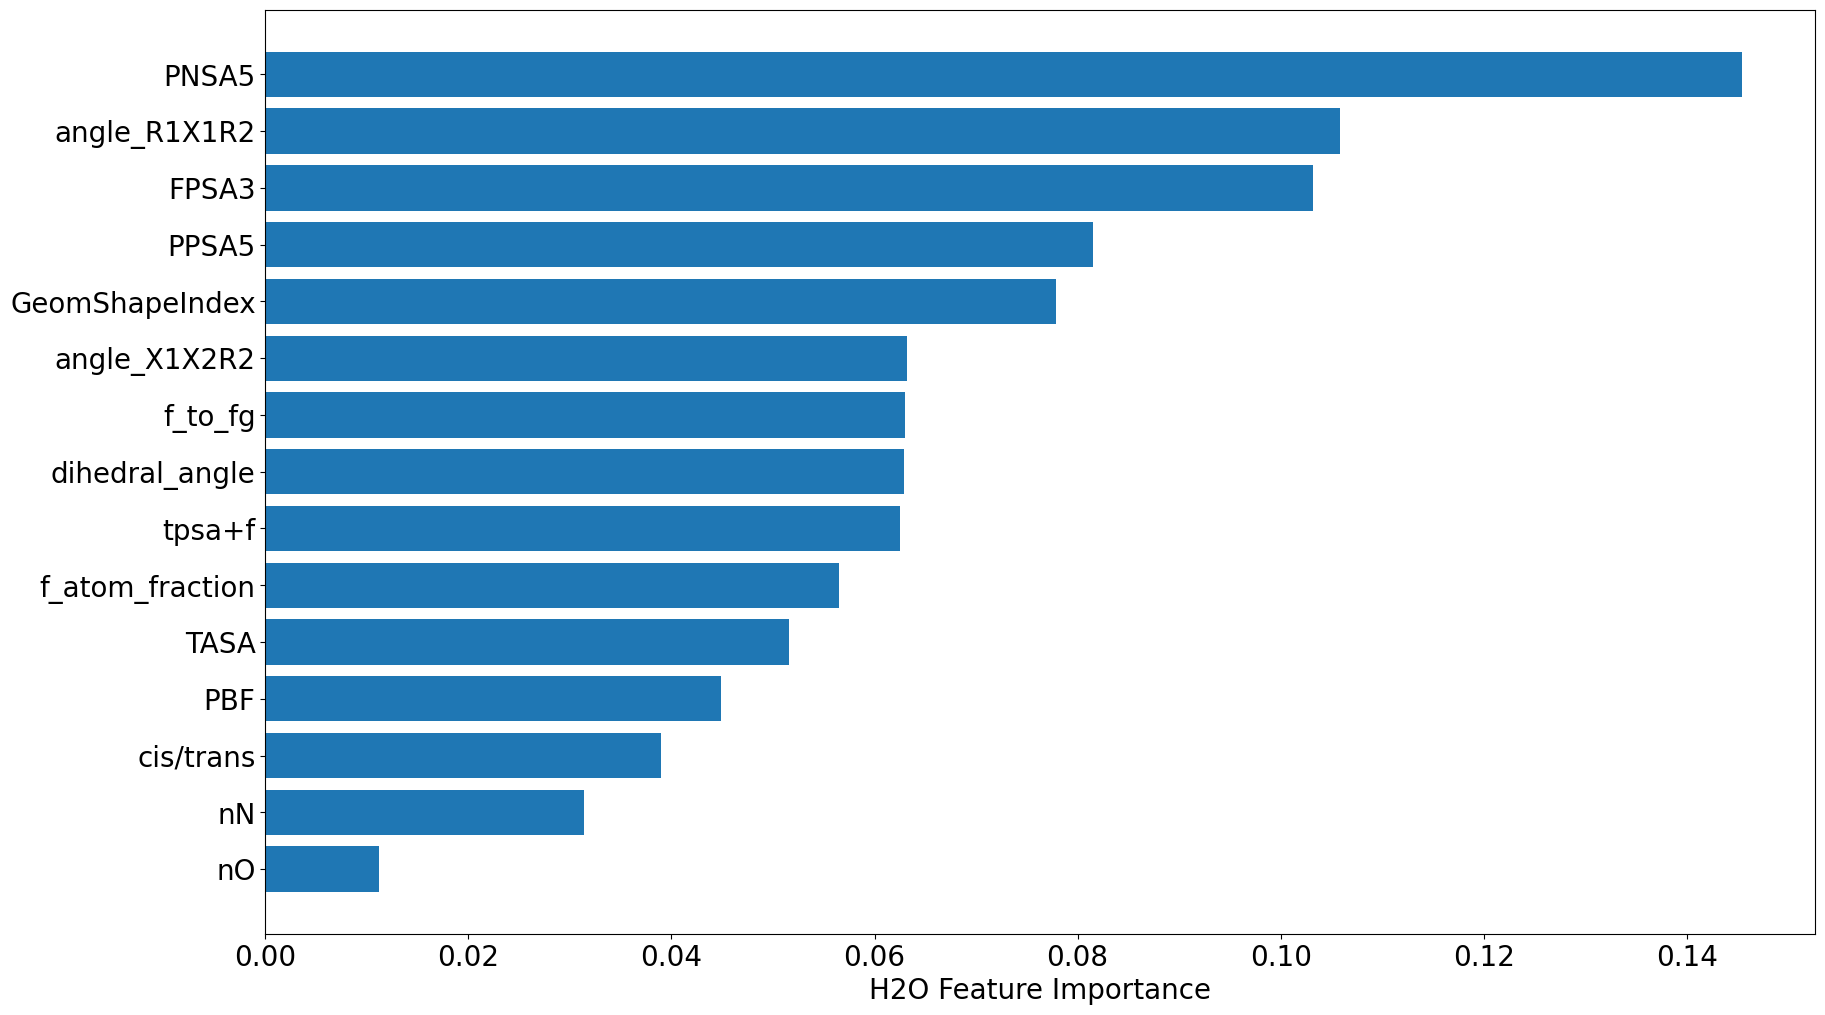

In [32]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

best_model = aml.get_best_model()
permutation_varimp = best_model.permutation_importance(train, use_pandas=True, n_repeats=500)

sum_rows = permutation_varimp.sum(axis=1)
sum_rows = sum_rows / sum(sum_rows)

sorted_idx = sum_rows.argsort()
plt.figure(figsize=(20,12))
plt.barh(sum_rows.keys()[sorted_idx][::-1][:30][::-1], sum_rows[sorted_idx][::-1][:30][::-1])
plt.xlabel("H2O Feature Importance")

SHAP

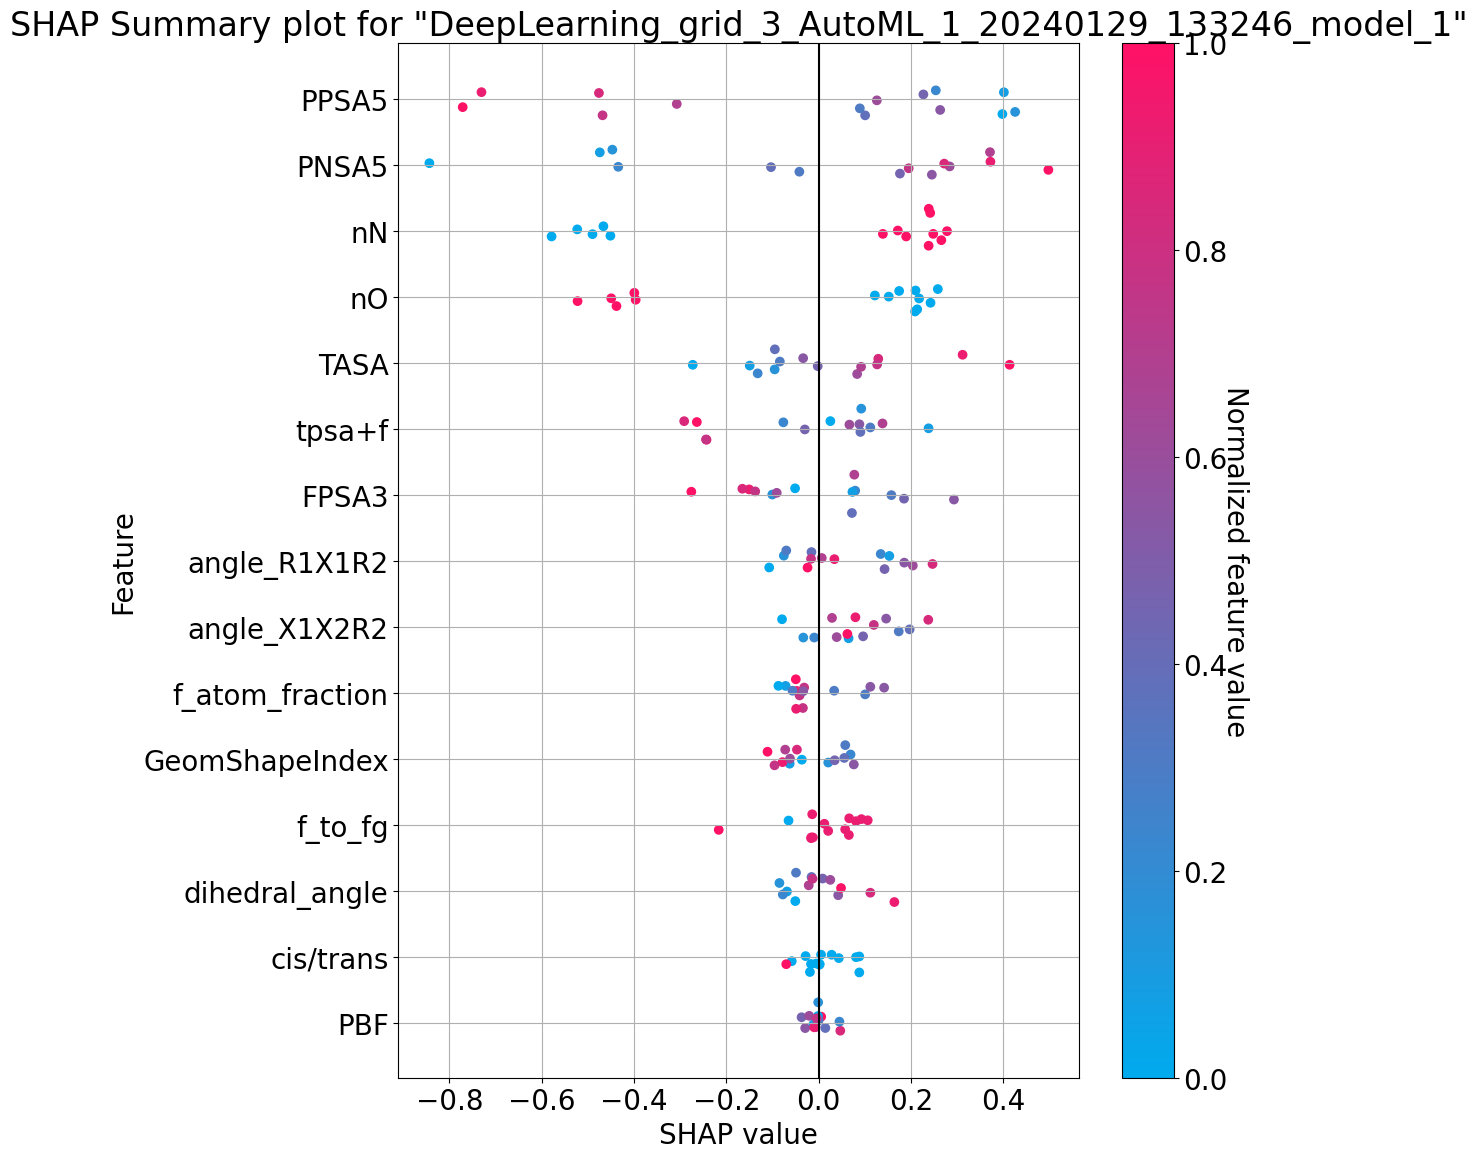

In [33]:
shap_plot = best_model.shap_summary_plot(test, background_frame=train, samples=2000)

VAR IMPORTANCE

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\h2o\frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Text(0.5, 0, 'Percent')

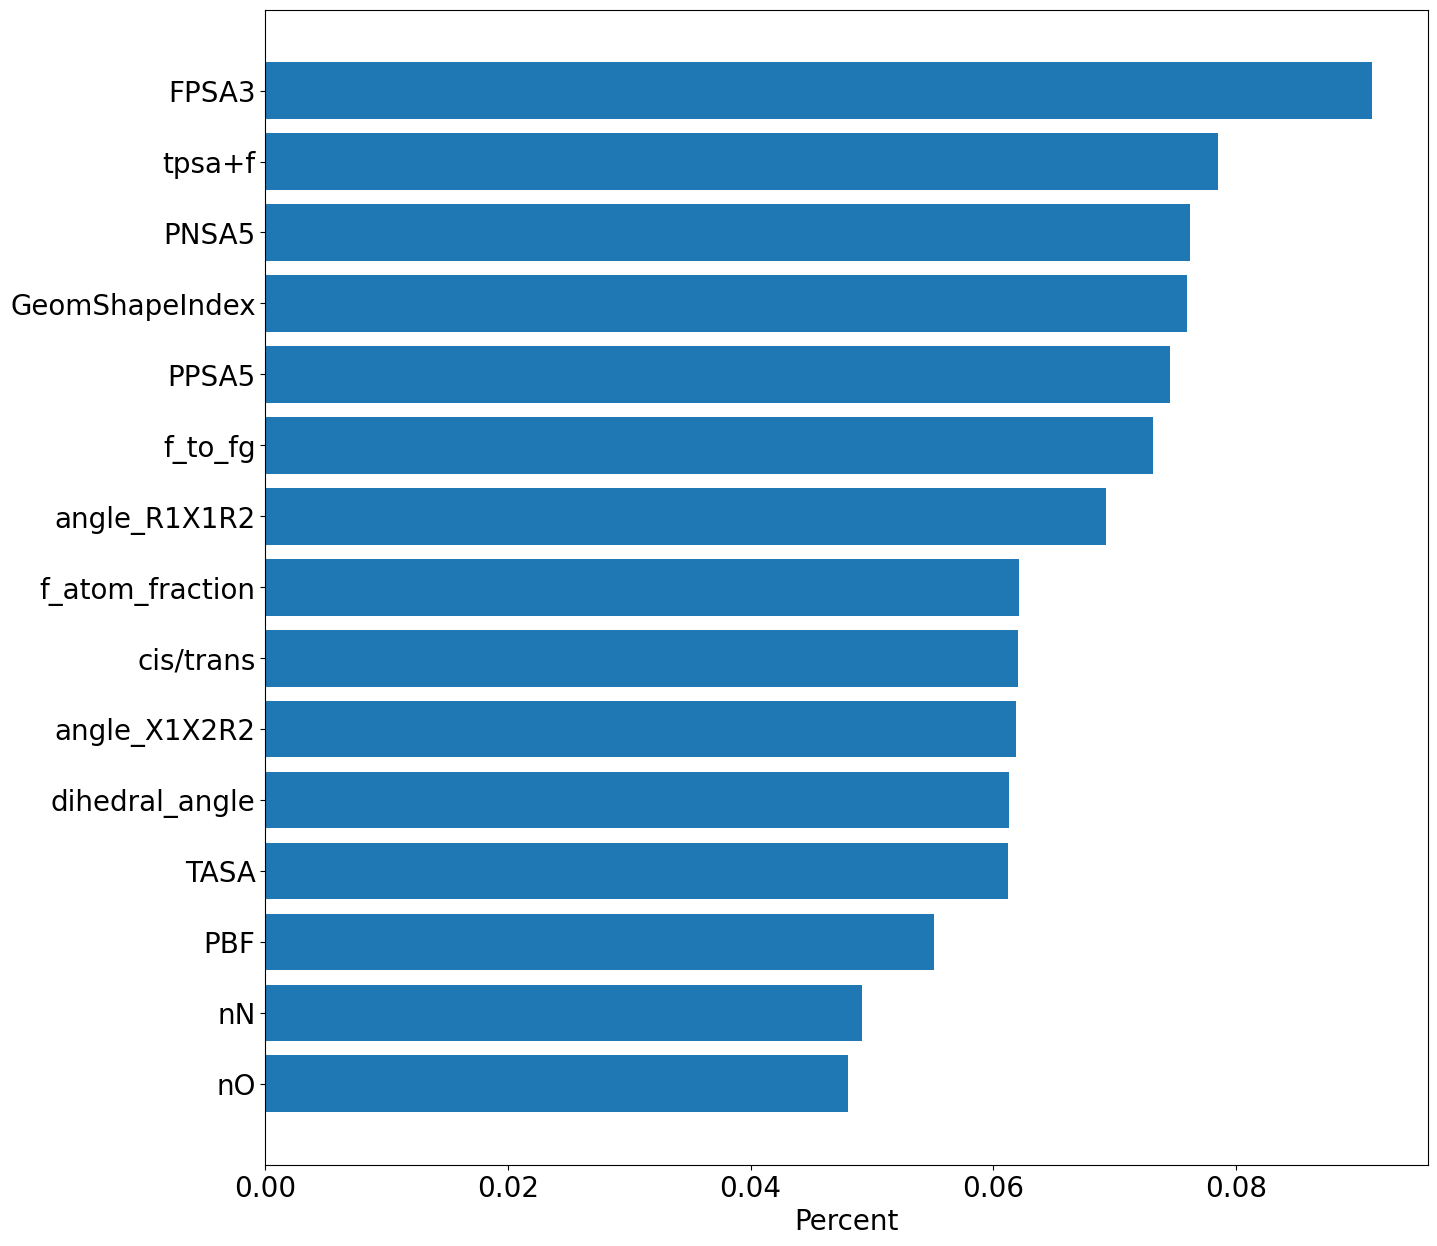

In [34]:
import matplotlib.pyplot as plt

best_model = aml.get_best_model()

preds = best_model.predict(test)
true = test.as_data_frame()['pKa']
predicted_values = preds.as_data_frame()['predict']

calculate_metrics(true, predicted_values)

importance = best_model.varimp(test)

fig, ax = plt.subplots(figsize=(15, 15))
ax.barh(importance['variable'][:][::-1], importance['percentage'][:][::-1])
ax.set_xlabel('Percent')


BEST MODEL SAVING

In [35]:
import os

MODEL_SAVE_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\h2o_model\models\25.01.24_features\pKa'

best_model = aml.get_best_model()

model_path = h2o.save_model(model=best_model, path=os.path.join(MODEL_SAVE_PATH, 'only_mol_with_dihedral_angle(angles_as_features included)_without_outliers_only_top_15_features'), force=True)
model_path

'C:\\work\\DrugDiscovery\\main_git\\XAI_Chem\\ml_part\\h2o_model\\models\\25.01.24_features\\pKa\\only_mol_with_dihedral_angle(angles_as_features included)_without_outliers_only_top_15_features\\DeepLearning_grid_3_AutoML_1_20240129_133246_model_1'

In [26]:
best_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_3_20240127_235113_model_1848


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          10027                  4            6            5.66          7             13            11.36

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.00605338677780054
RMSE: 0.0778035139167926
MAE: 0.05715318852000766
RMSLE: 0.010433953243173583
Mean Residual Deviance: 0.00605338677780054

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1.3433761000273146
RMSE: 1.1590410260328643
MAE: 0.8514800830942897
RMSLE: 0.15331788696020052
Mean Residual Deviance: 1.3433761000273146

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid
----------------------  --------  ---------  ------------  ------------
mae                     0.852866  0.070562   0.902761      0.802971
mean_residual_deviance  1.35049   0.362343   1.60671       1.09428
mse                     1.35049   0.362343   1.60671       1.09428
r2                      0.678543  0.0247446  0.69604       0.661046
residual_deviance       1.35049   0.362343   1.60671       1.09428
rmse                    1.15682   0.156612   1.26756       1.04608
rmsle                   0.151384  0.0407859  0.180224      0.122544

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2024-01-27 23:56:35  5 min 20.732 sec  0                  2.06799          1.72709         4.2766
    2024-01-27 23:56:35  5 min 20.741 sec  5                  1.27488          1.0659          1.62531
    2024-01-27 23:56:35  5 min 20.749 sec  10                 0.803333         0.67012         0.645344
    2024-01-27 23:56:35  5 min 20.758 sec  15                 0.527906         0.442901        0.278685
    2024-01-27 23:56:36  5 min 20.766 sec  20                 0.364082         0.303888        0.132556
    2024-01-27 23:56:36  5 min 20.795 sec  25                 0.260893         0.212446        0.0680653
    2024-01-27 23:56:36  5 min 20.803 sec  30                 0.195343         0.151252        0.038159
    2024-01-27 23:56:36  5 min 20.814 sec  35                 0.147712         0.110922        0.0218187
    2024-01-27 23:56:36  5 min 20.823 sec  40                 0.115726         0.0845342       0.0133925
    2024-01-27 23:56:36  5 min 20.831 sec  45                 0.0956273        0.0699895       0.00914459
    2024-01-27 23:56:36  5 min 20.839 sec  50                 0.0778035        0.0571532       0.00605339

Variable Importances: 
variable            relative_importance    scaled_importance       percentage
------------------  ---------------------  ----------------------  ----------------------
nO                  690.2229614257812      1.0                     0.42650783685256
nN                  359.4010009765625      0.5207027599229013      0.22208380777787448
PPSA5               118.5877456665039      0.17181078042019832     0.07327864430496894
f_atom_fraction     104.36639404296875     0.15120678371432464     0.0644908782394295
nF                  75.60542297363281      0.10953768158836101     0.046718679628096345
FPSA3               64.4099349975586       0.09331757793816094     0.0398006783067252
GeomShapeIndex      64.31148529052734      0.09317494329322261     0.03973984351285232
mol_volume          28.87727165222168      0.04183759924846663     0.017844063954567793
PBF                 25.7471675